In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

from keras_unet_collection import models

In [2]:
ds_train_xr = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Training_data/train.nc').isel(time = slice(300,500))

ds_val_xr = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Training_data/validate.nc').isel(time = slice(300,350))


In [11]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train_xr.features.values,ds_train_xr.labels_2d.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val_xr.features.values,ds_val_xr.labels_2d.values))

# #shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 8
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [12]:
for batch in ds_train:
    break 

2023-10-19 10:48:42.285292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [200,256,32,8]
	 [[{{node Placeholder/_0}}]]
2023-10-19 10:48:42.285665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [200,256,32]
	 [[{{node Placeholder/_1}}]]


In [13]:



model = models.unet_2d([256, 32, 8], [2,4], 1, stack_num_down=1, stack_num_up=1, output_activation='Sigmoid', weights=None)




In [14]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 32, 8)  0           []                               
                                ]                                                                 
                                                                                                  
 unet_down0_0 (Conv2D)          (None, 256, 32, 2)   146         ['input_1[0][0]']                
                                                                                                  
 unet_down0_0_activation (ReLU)  (None, 256, 32, 2)  0           ['unet_down0_0[0][0]']           
                                                                                                  
 unet_down1_encode_maxpool (Max  (None, 128, 16, 2)  0           ['unet_down0_0_activatio

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=10)


Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.7077

2023-10-19 10:48:58.889498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,256,32]
	 [[{{node Placeholder/_1}}]]


25/25 [==============================] - 5s 163ms/step - loss: 0.7077 - val_loss: 0.6768
Epoch 2/10
25/25 [==============================] - 4s 158ms/step - loss: 0.6690 - val_loss: 0.6620
Epoch 3/10
25/25 [==============================] - 4s 158ms/step - loss: 0.6564 - val_loss: 0.6501
Epoch 4/10
25/25 [==============================] - 4s 148ms/step - loss: 0.6448 - val_loss: 0.6386
Epoch 5/10
25/25 [==============================] - 4s 148ms/step - loss: 0.6334 - val_loss: 0.6273
Epoch 6/10
25/25 [==============================] - 4s 152ms/step - loss: 0.6223 - val_loss: 0.6163
Epoch 7/10
25/25 [==============================] - 4s 148ms/step - loss: 0.6113 - val_loss: 0.6054
Epoch 8/10
25/25 [==============================] - 4s 152ms/step - loss: 0.6006 - val_loss: 0.5948
Epoch 9/10
25/25 [==============================] - 4s 162ms/step - loss: 0.5902 - val_loss: 0.5844
Epoch 10/10
25/25 [==============================] - 4s 158ms/step - loss: 0.5799 - val_loss: 0.5742


7/7 [==============================] - 0s 12ms/step


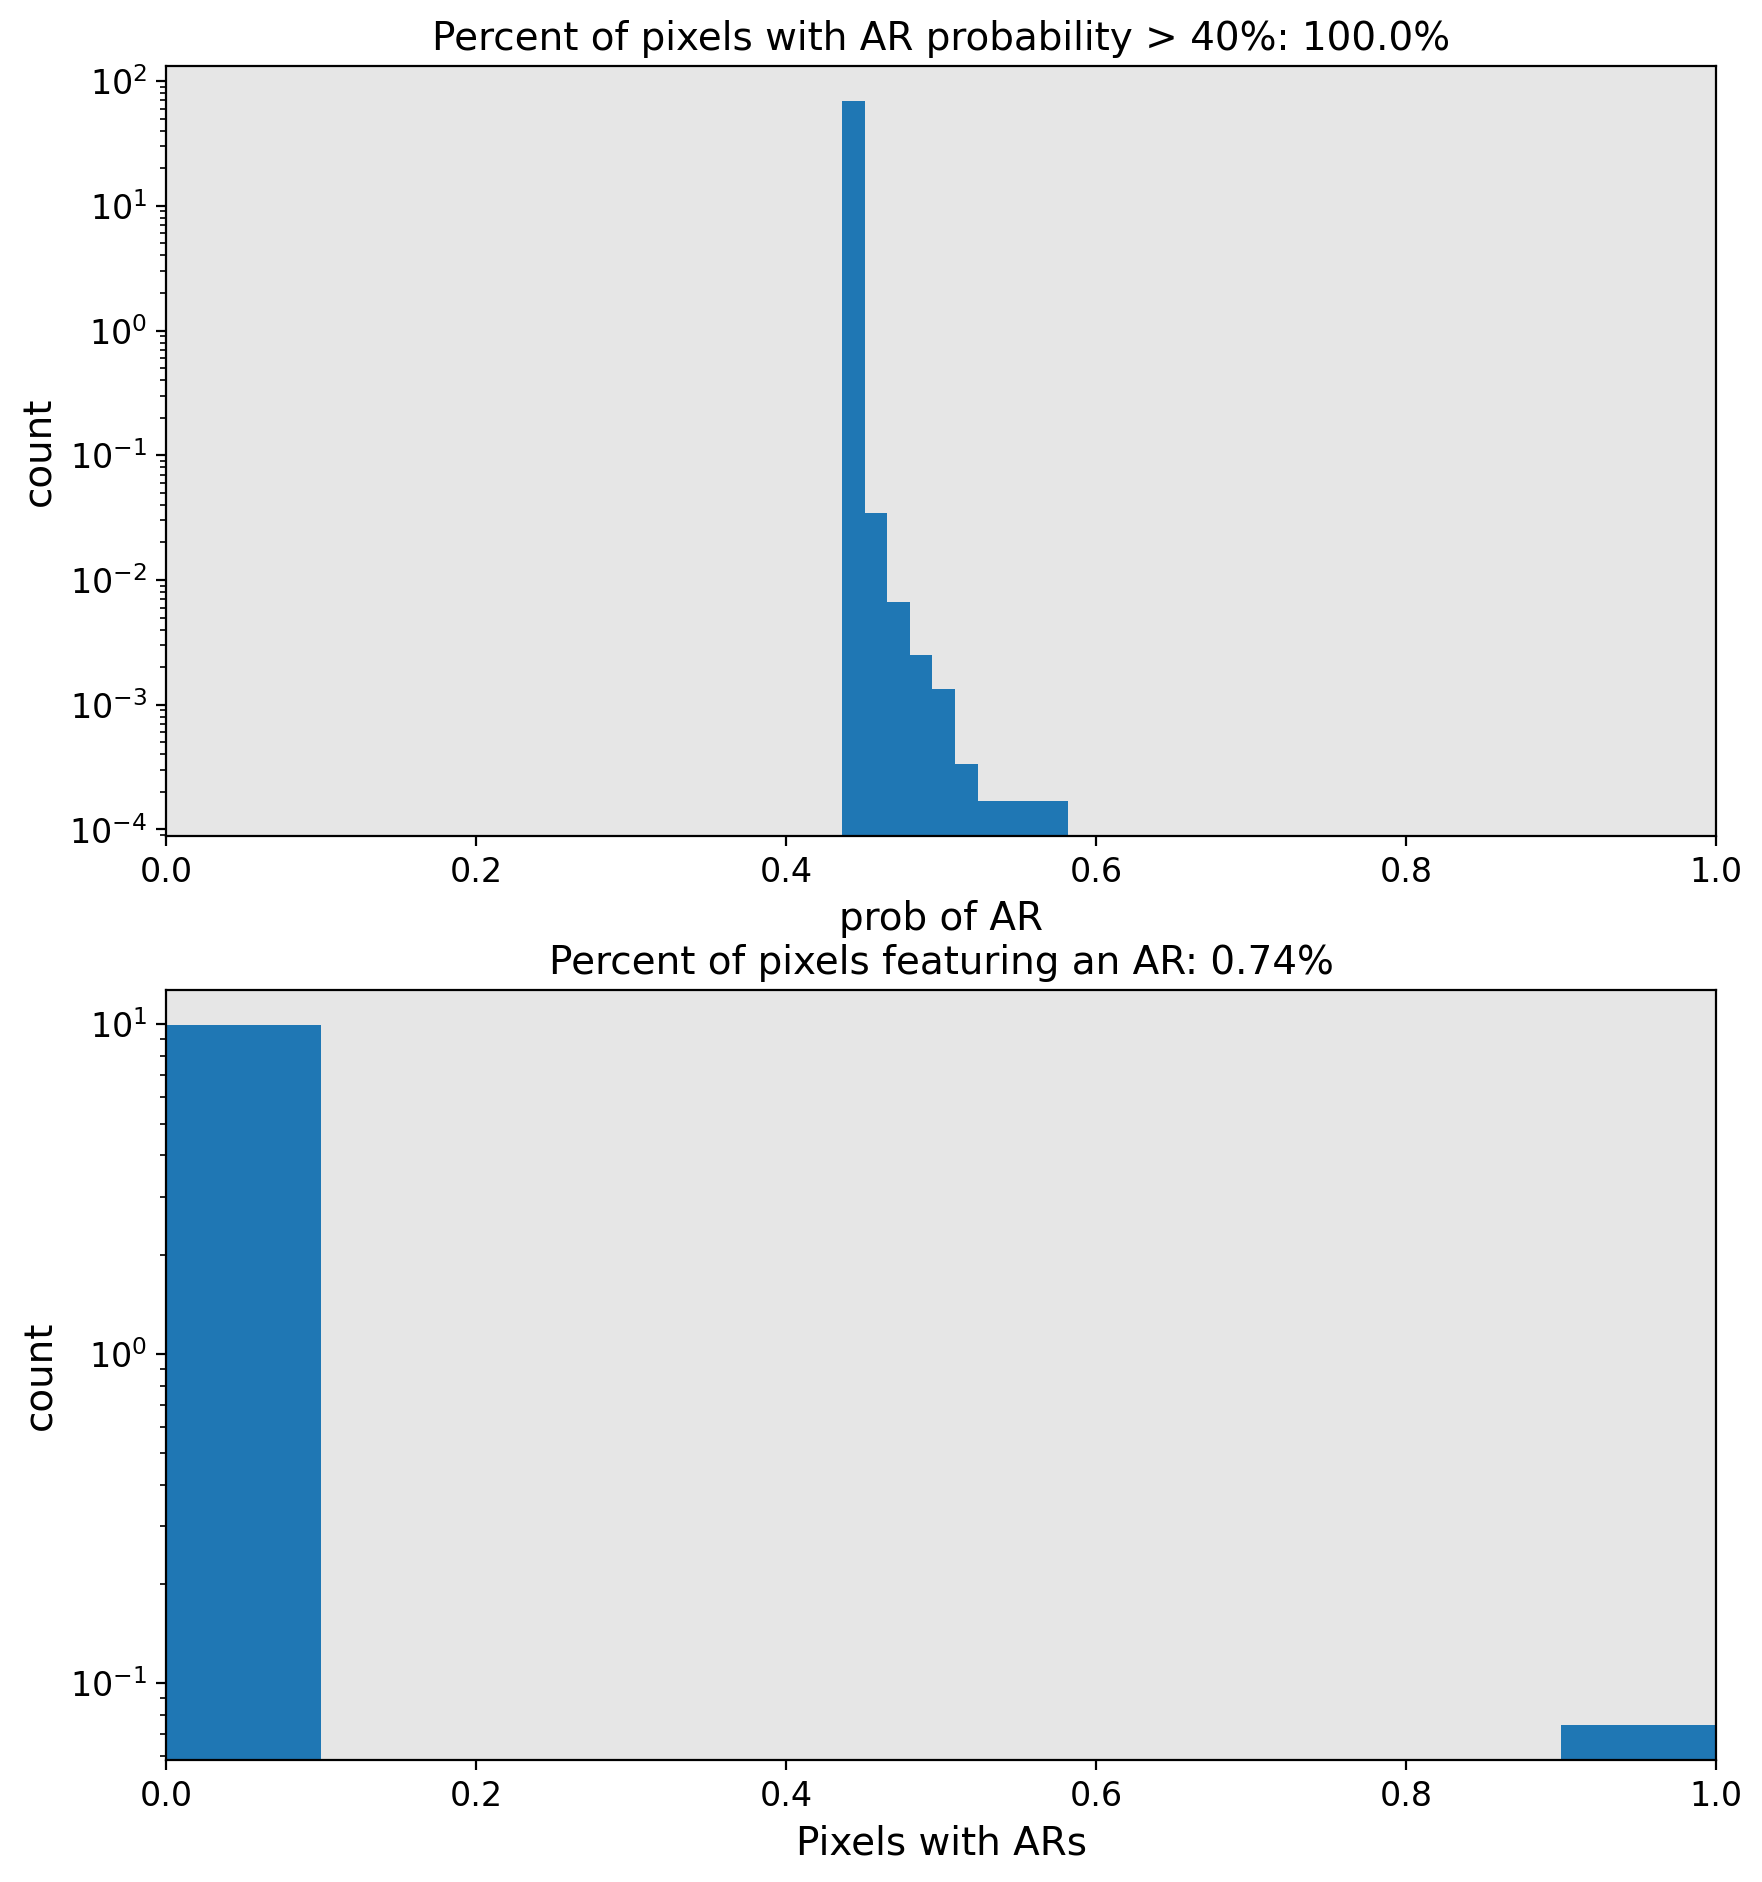

In [17]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

val_y = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Training_data/validate.nc').isel(time = slice(0,100))
val_y = val_y.labels_2d.values

fig,ax = plt.subplots(2,1,figsize=(10, 11))

ax[0].set_title('Percent of pixels with AR probability > 40%: '+ str(np.round(len(np.where(y_preds.ravel()>=.4)[0])/len(y_preds.ravel())*100,2))+ '%')
ax[0].hist(y_preds.ravel(), density = True)
ax[0].set_xlabel('prob of AR')
ax[0].set_ylabel('count')
ax[0].set_xlim([0,1])
ax[0].set_yscale('log')


ax[1].set_title('Percent of pixels featuring an AR: '+ str(np.round(len(np.where(val_y.ravel()==1)[0])/len(val_y.ravel())*100,2))+ '%')
ax[1].hist(val_y.ravel(), density = True)
ax[1].set_xlabel('Pixels with ARs')
ax[1].set_ylabel('count')
ax[1].set_xlim([0,1])
ax[1].set_yscale('log')

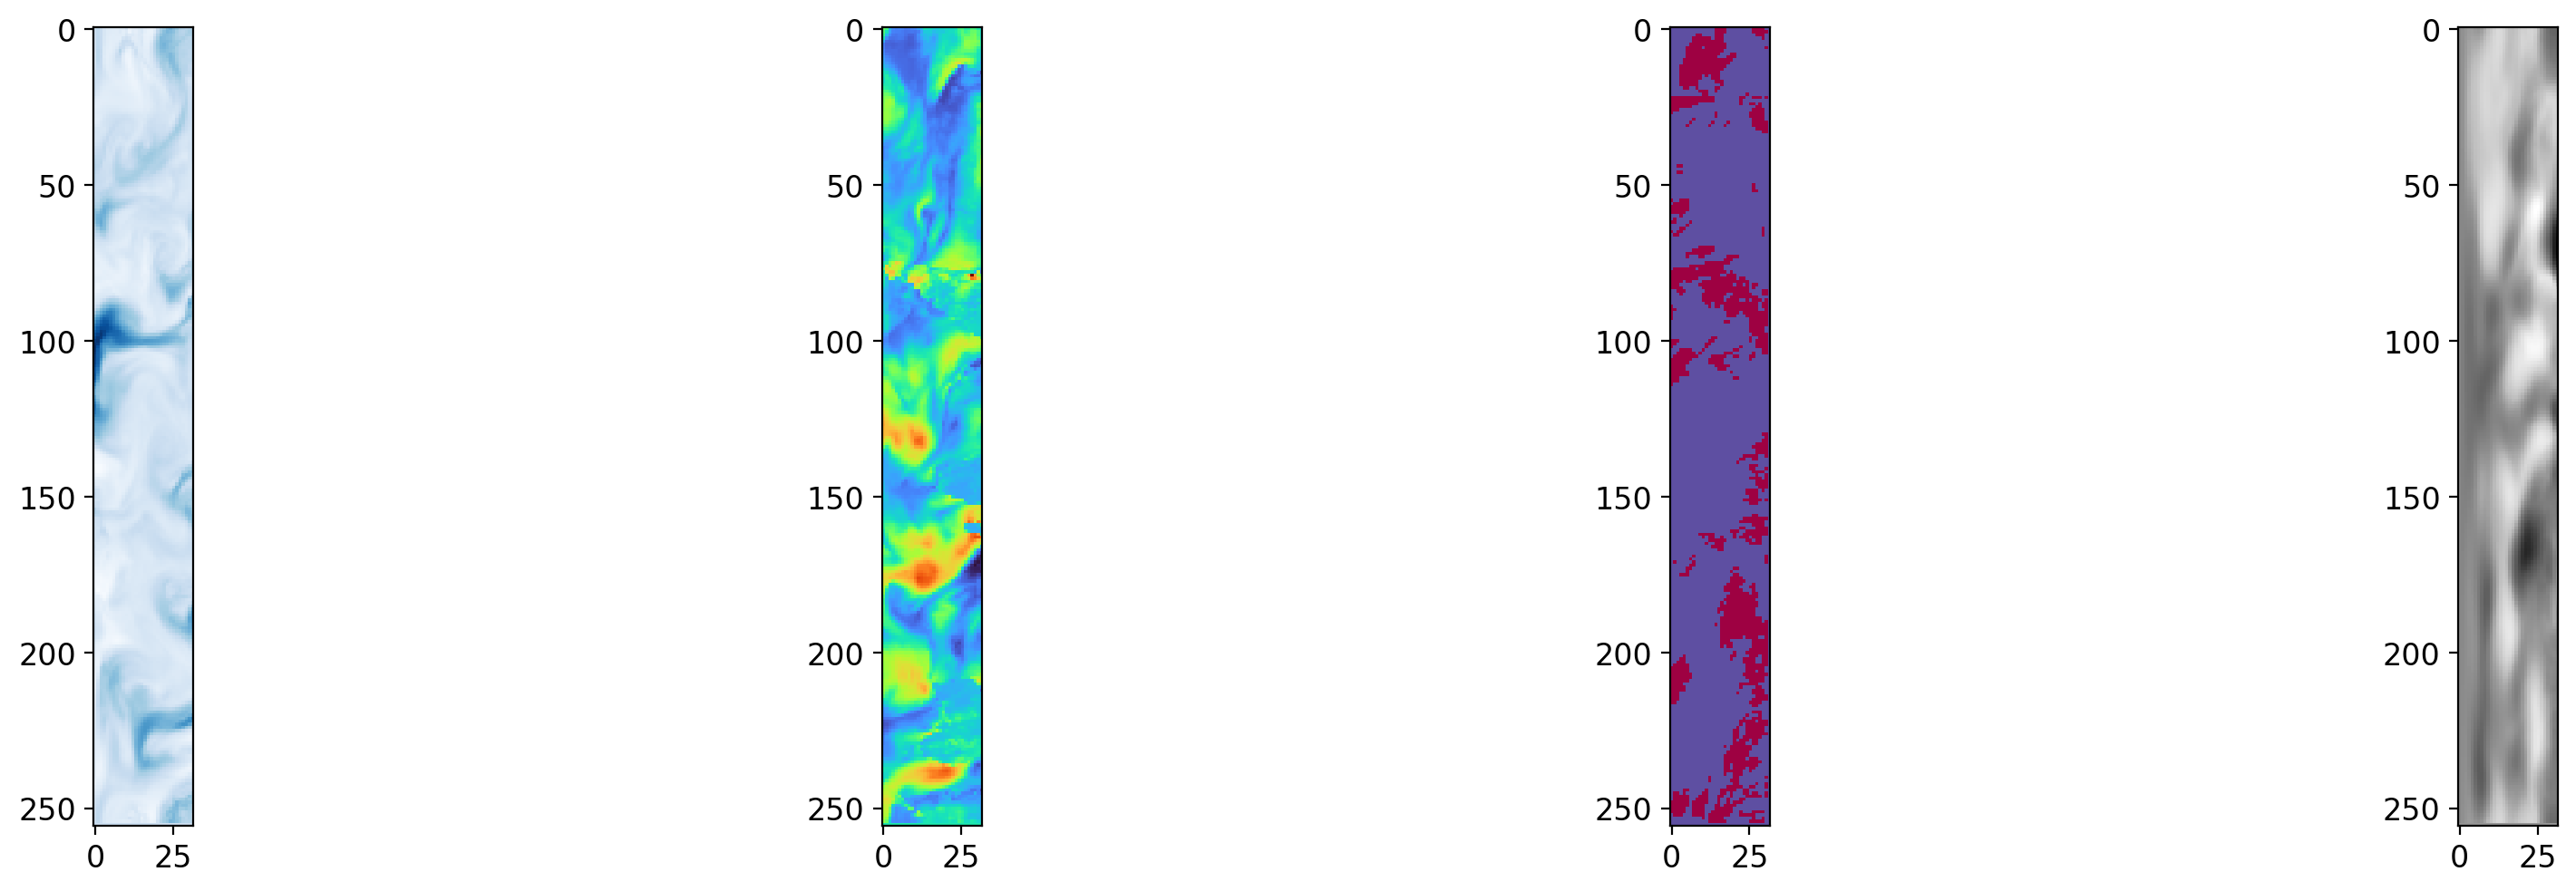

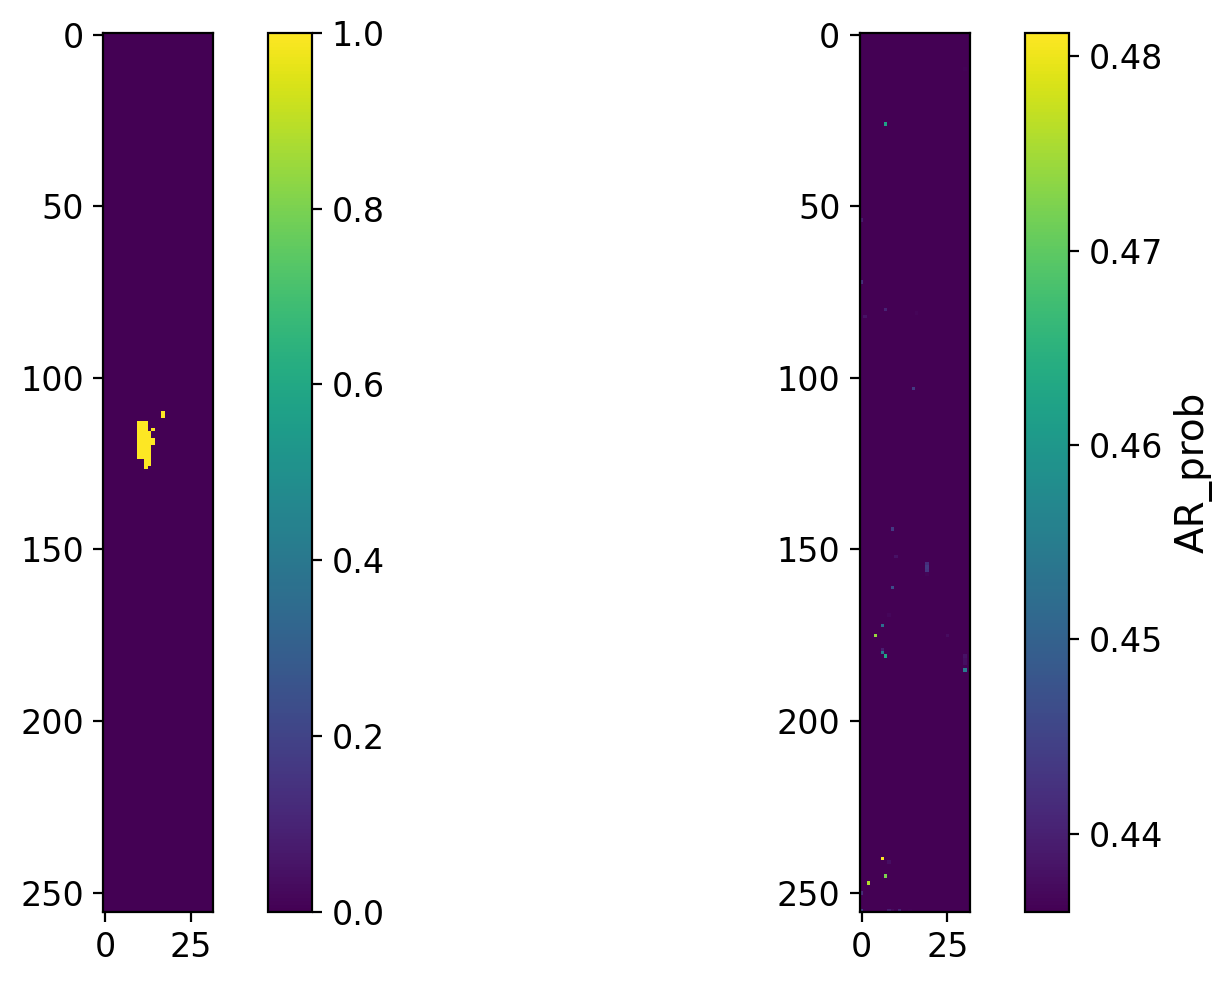

In [21]:
i = 1
#get the features for example 12 in this batch 
one_example_features = batch[0][i]
#get the label for that same example 
one_example_label = batch[1][i]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[i])
plt.colorbar(pm,ax=axes[1],label='AR_prob')


plt.tight_layout()

In [23]:
import copy 
for i,(_,y) in enumerate(ds_val):
    if i == 0:
        y_v = copy.deepcopy(y)
    else:
        y_v = np.concatenate([y_v,y])

#ravel both
y_v_rav = y_v.ravel()
y_preds_rav = y_preds.ravel()

In [32]:
np.shape(y_preds) 256, 32

(50, 256, 32, 1)

In [29]:
np.shape(y_v.reshape((np.shape(np.squeeze(y_v))[0], np.shape(np.squeeze(y_v))[1]*np.shape(np.squeeze(y_v))[2])))

(50, 8192)

In [30]:
np.shape(np.squeeze(y_preds).reshape((np.shape(np.squeeze(y_preds))[0], np.shape(np.squeeze(y_preds))[1]*np.shape(np.squeeze(y_preds))[2])))




(50, 8192)

In [80]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

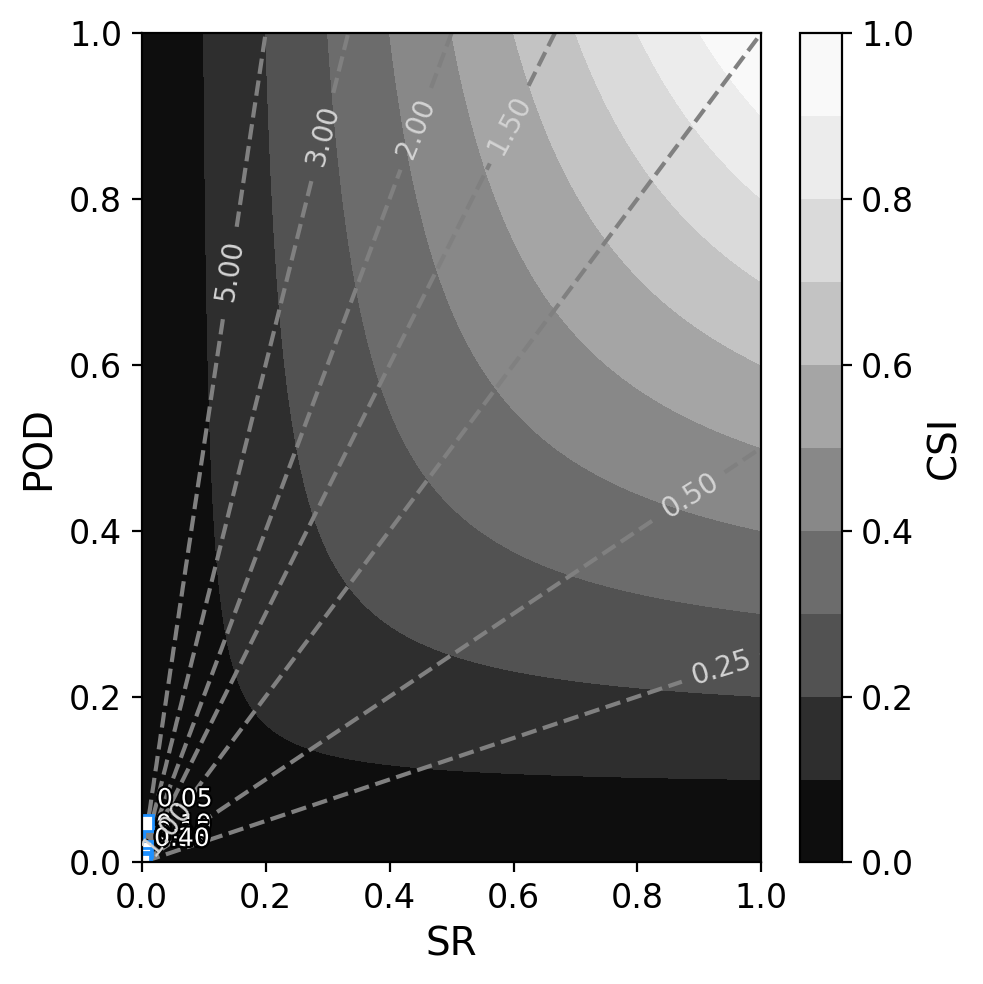

In [81]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()